In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [1]:
import keras
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Activation , Dropout, Flatten
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import collections
from keras.layers import  MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.optimizers import Adam, SGD
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import itertools

Using TensorFlow backend.


# Laboratorio: Convolutional Neural Networks

En este laboratorio, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


In [0]:
import cv2
import os
import numpy as np 
import keras
import matplotlib.pyplot as plt
import glob


# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets

# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

In [0]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [0]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [0]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [6]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X_train, Y_train = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_test, Y_test = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)


Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [0]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X_train))
X_train, Y_train = X_train[perm], Y_train[perm]

## Entregable

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

**Análisis de los datos a utilizar**

El dataset de **entrenamiento** consta de un total de 18992 imagenes en color, con un tamaño de 64 pixels de ancho por 64 pixels de alto, tenemos 3 canales, que son: R(red), G(green) y B(blue).
El dataset de **prueba** consta de un total de 890 imagenes en color y sus imagenes tienen el mismo tamaño que las imagenes del dataset de entrenamiento, a continuación mostramos las estructuras de los datasets de entrenamiento y prueba: 

In [8]:
print("Estructura del dataset de entrenamiento: " +str(X_train.shape))
print("Estructura del dataset de prueba: " +str(X_test.shape))


Estructura del dataset de entrenamiento: (18992, 64, 64, 3)
Estructura del dataset de prueba: (890, 64, 64, 3)


Los valores de los píxeles están en el rango de 0 a 255, con 0 para el negro y 255 para el blanco, para nuestro análisis procederemos a realizar una normalización y el rango de los valores  se encontrará entre 0 y 1 facilitando los cálculos, para ello dividimos por el valor máximo 255.

In [0]:
# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

Realizamos una transformación de la forma de los dataset de etiquetas o resultados esperados; vamos a crear un vector de 18 celdas, donde cada celda se corresponde con una de las categorías de las imágenes, así: dada la categoría de una imagen correspondiente al número **2 - bart_simpson ** entonces se tiene un vector con un **1** en la posición  **2** del vector y el **resto** de celdas con **0** como el siguiente vector [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]. 
Lo anterior lo hacemos para que cada celda se corresponda con una neurona softmax en la capa de salida de la red neuronal. 

In [0]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
labels=Y_train;
labels_test=Y_test;
Y_train = keras.utils.to_categorical(Y_train, num_classes = 18)
Y_test = keras.utils.to_categorical(Y_test, num_classes = 18)

Aquí mostramos unas pocas imágenes del dataset para una mejor comprensión de los datos de análisis.

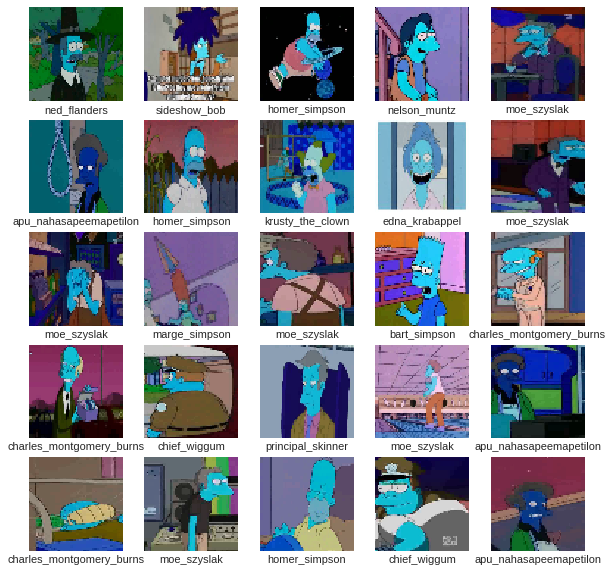

In [11]:
class_names = ['abraham_grampa_simpson', 'apu_nahasapeemapetilon', 'bart_simpson',
     'charles_montgomery_burns', 'chief_wiggum', 'comic_book_guy', 'edna_krabappel', 
     'homer_simpson',  'kent_brockman',  'krusty_the_clown',  'lisa_simpson', 
     'marge_simpson', 'milhouse_van_houten',  'moe_szyslak', 
    'ned_flanders',  'nelson_muntz', 'principal_skinner',  'sideshow_bob']


plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[labels[i]])

En seguida encontraremos varias funciones utilizadas para realizar gráficas de distintos indicadores

In [0]:
def plot_confusion_matrix(cm, num_classes,
                          normalize=False,
                          title='Matrix de Confusion',
                          cmap=plt.cm.Blues):

    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Original')
    plt.xlabel('Predicciones')
    
    
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    

Entramos en la parte medular de la red neural, esta red consta de las siguientes capas:


1.   Input: imágenes de 64x64x3.
2.   Primer bloque:
> Conv2dD(32 neuronas,  filtro 3x3)
> Activacion(Relu)
3.   Segundo bloque:
> Conv2dD(32 neuronas,  filtro 3x3)
> Activacion(Relu)
> MaxPooling2D(3x3)
> Dropout(0.2)
4.   Tercer bloque:
> Conv2dD(64 neuronas, filtro 3x3) 
> Activacion(Relu)
5.   Cuarto bloque:
> Conv2dD(64 neuronas, filtro 3x3) 
> Activacion(Relu)
6.   Quinto bloque:
> Conv2dD(256 neuronas,  filtro 3x3)
> Activacion(Relu)
> MaxPooling2D(3x3)
> Dropout(0.2)
7.   Sexto bloque:
> Conv2dD(256 neuronas, filtro 3x3) 
> Activacion(Relu)
> MaxPooling2D(3x3)
> Dropout(0.2)
> Flatten()
8.   Septimo bloque:
> Dense(1024)
> Activation(Relu)
9.   Octavo bloque:
> Dense(18 neuronas y softmax)


In [13]:
input_shape = (64, 64, 3)
batch_size = 128
num_classes = 18
epochs = 15

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(256, (3, 3), padding='same')) 
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))

model.add(Dense(num_classes, activation='softmax'))

model.summary()
    


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
__________

En la compilación del modelo utilizaremos un optimizador SGD.

In [0]:
model.compile(loss='categorical_crossentropy',optimizer=SGD(lr=0.009, decay=1e-6, momentum=0.9, nesterov=True),metrics=['accuracy'])

Con ImageDataGenerator generamos un conjunto de imágenes aleatorias y se aplicarán algunos efectos sobre las mismas, aplicando la técnica de data augmentation.

In [0]:
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False, 
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        width_shift_range=0.1,  
        height_shift_range=0.1, 
        horizontal_flip=True,  
        vertical_flip=False)


Con *datagen.fit* calculamos los parámetros requeridos para una normalización funcional.

Y con *model.fit_generator* enlazamos el modelo en lotes con datos en tiempo real, agregamos el parámetro nb_val_samples para determinar cuantas muestras sobre los datos de entrenamiento evalúa el modelo después de terminar cada época, para este caso solo tomamos el 20% de los datos.

In [16]:
datagen.fit(X_train)
    
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              steps_per_epoch=len(X_train) / 32, 
                              epochs=epochs,validation_data=(X_test, Y_test),
                              nb_val_samples=0.2)

# evalua los indicadores de loss y accuracy
score = model.evaluate(X_test,Y_test, verbose=0)
print('\nKeras CNN - accuracy:', score[1])
print('')

# genera las salidas predichas para los ejemplo de ingreso
y_pred = model.predict(X_test)
print('\n', metrics.classification_report(
    np.where(Y_test > 0)[1], np.argmax(y_pred, axis=1), 
    target_names=list(MAP_CHARACTERS.values())), sep='') 

Y_pred_classes = np.argmax(y_pred, axis = 1) 
Y_true = np.argmax(Y_test, axis = 1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., steps_per_epoch=593.5, epochs=15, validation_data=(array([[[..., validation_steps=0.2)`
  


Epoch 1/15
594/593 [==============================] - 113s 189ms/step - loss: 2.2030 - acc: 0.3217 - val_loss: 1.4899 - val_acc: 0.5596
Epoch 2/15
594/593 [==============================] - 110s 185ms/step - loss: 1.1427 - acc: 0.6557 - val_loss: 0.7456 - val_acc: 0.7854
Epoch 3/15
594/593 [==============================] - 111s 187ms/step - loss: 0.7336 - acc: 0.7765 - val_loss: 0.4470 - val_acc: 0.8730
Epoch 4/15
594/593 [==============================] - 112s 189ms/step - loss: 0.5407 - acc: 0.8354 - val_loss: 0.3132 - val_acc: 0.9079
Epoch 5/15
594/593 [==============================] - 112s 189ms/step - loss: 0.4337 - acc: 0.8654 - val_loss: 0.2350 - val_acc: 0.9326
Epoch 6/15
594/593 [==============================] - 112s 189ms/step - loss: 0.3553 - acc: 0.8896 - val_loss: 0.1529 - val_acc: 0.9573
Epoch 7/15
594/593 [==============================] - 110s 185ms/step - loss: 0.3011 - acc: 0.9061 - val_loss: 0.1502 - val_acc: 0.9551
Epoch 8/15
594/593 [============================

El **modelo** de CNN obtenido muestra una capacidad de **predicción** casi **perfecta**, las imagenes homer_simpson, krustry_the_clown, lisa_simpson y sideshow_bob son las que tienen **peores indicadores** y sin embargo su **precisión** llega al **98%**.

Comparando los modelos CNNs con los modelos de Fully Connected, podemos observar lo siguiente:
CNNs: 
--- 
* El entrenamiento es mucho mas rápido
* La precisión del modelo es mucho mejor que en las Fully Connected
* Con pocas epochs se puede entrenar el modelo y tener muy buenos resultados
* El uso de filtros en las CNN contribuye a la mejora en los resultados del modelo porque permiten tener información mas profunda acerca de la imagen, adicionalmente nos ahorran el uso de parámetros.

Fully Connected:
--- 
* El entrenamiento puede tomar mucho tiempo
* Se requieren muchas epochs para entrenar el modelo y obtener buenos resultados
*  La cantidad de parámetros se incrementa dramáticamente en el momento en el que usamos capas tipo Dense(Fully Connected) tal como se ve en el resumen del modelo, por eso en las redes Fully Connected los parámetros siempre van a aumentar y esto incrementa los tiempos de entrenamiento y coste computacional.

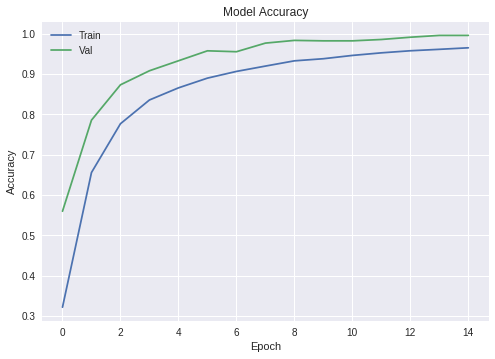

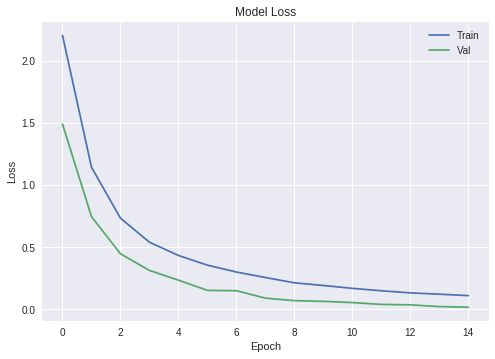

In [17]:
# Mostramos el diagrama de comparación de accuracy entre los datos de entrenamiento y los de validación 
plt.subplot(1,1,1)
plot_acc(history)

# Mostramos el diagrama de comparación de loss entre los datos de entrenamiento y los de validación 
plt.subplot(1,1,1)
plot_loss(history)

Es muy interesante el resultado de accuracy más alto en los datos de validación que en los datos de entrenamiento, el modelo obtenido entrega resultado de predicción mejores que en el entrenamiento. Las curvas de accuracy siguen mejorando tanto para los datos de test como para los datos de validación según aumentan las épocas, este comportamiento indica que no existe overfitting en el modelo. Si las curvas se cruzan y aumenta el accuracy para el entrenamiento y disminuye el accuracy de los datos de las pruebas, se podría pensar en un sobreajuste del modelo. 

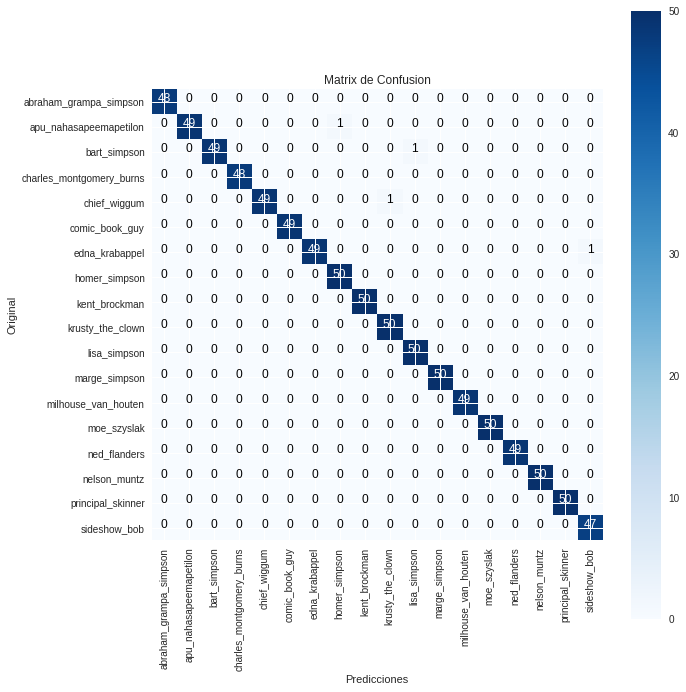

In [28]:
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, num_classes = list(MAP_CHARACTERS.values()))

Como se puede ver la mayoría de los resultado se encuentran en la diagonal correctamente predichos y si hay algún error de predicción es mínimo (ver valores por encima y debajo de la diagonal).
####Función de dibujo de imagenes predichas correcta (etiquetas en verde) e incorrectamente (etiquetas en rojo)

In [0]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'green'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)


A continuación, se almacena el modelo en disco.

In [0]:
#model.save("/content/gdrive/My Drive/app/model.h5")
#model.save_weights('/content/gdrive/My Drive/app/my_model_weights.h5')
model.save("/root/.keras/datasets/model.h5")
model.save_weights('/root/.keras/datasets/my_model_weights.h5')

A continuación, veremos algunas imágenes con sus respectivas etiquetas y  precisión de acuerdo a los resultados del modelo.

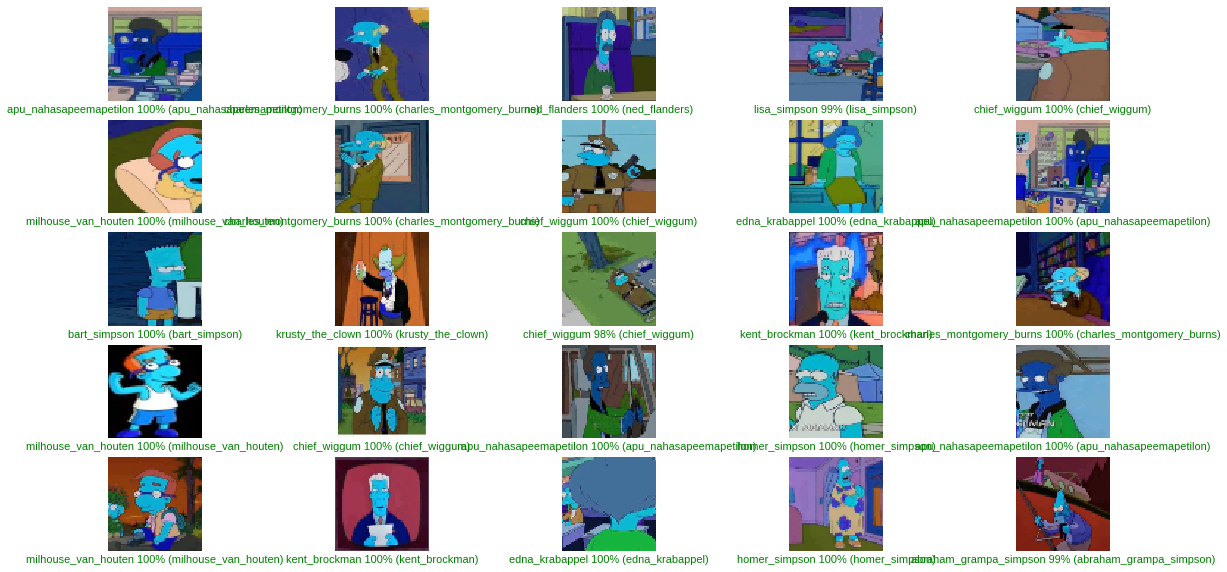

In [30]:
num_rows = 5
num_cols = 5
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, y_pred, labels_test, X_test)
